Parameter tuning and model selection.

In this notebook, I tune parameters to find the best models to recommend books from my data. I want an end result of two potential models: One tuned for speed so it can be used in near real time as a part of a dynamic recommender service, and one tuned for maximum performance. I will use RMSE as my evaluation metric.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import math
import random

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate

In [2]:
## Loading the data

# df_books comes from my BlurbCleaning notebook and is a table of all the books in the dataset
# that I was able to scrape Blurbs for.
df_books = pd.read_csv('/DataScience/Final Capstone Files/books_with_popularities.csv')

# df_ratings is the ratings table from the book-crossings dataset
df_ratings = pd.read_csv('/DataScience/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding = "latin-1")
df_ratings.rename(columns={'User-ID': 'User', 'Book-Rating': 'Rating'}, inplace=True)
df_ratings = df_ratings[df_ratings['Rating'] > 0]
df_ratings.reset_index(inplace=True, drop=True)

Before modeling using SVD, I want to try to develop some baseline models to compare my results with. The following 2 cells are naive models.

In [4]:
## User average baseline
# Predict each rating by the average rating that user has made.
rmses, cv = [], 3
shuffled = df_ratings.sample(frac=1).copy()
for chunk in range(cv):
    test_set = shuffled.iloc[chunk * (len(shuffled) // cv) : (chunk + 1) * (len(shuffled) // cv), :]
    train_set = shuffled[~shuffled.index.isin(test_set.index)]
    RMSE, count = 0, 0
    for rating in range(len(test_set)):
        if len(train_set[train_set.User == test_set.iloc[rating, 0]]) > 0:
            RMSE += (test_set.Rating.iloc[rating] - np.mean(train_set.Rating[train_set.User == test_set.iloc[rating, 0]])) ** 2
            count += 1
    RMSE = (RMSE / count) ** 0.5
    rmses.append(RMSE)
print("Average RMSE:", sum(rmses)/cv)


Average RMSE: 1.6832489522972125


In [35]:
## Book average baseline
# Predict each rating by the average rating that book has received.
rmses, cv = [], 1
shuffled = df_ratings.sample(frac=1).copy()
for chunk in range(cv):
    test_set = shuffled.iloc[chunk * (len(shuffled) // 5) : (chunk + 1) * (len(shuffled) // 5), :]
    train_set = shuffled[~shuffled.index.isin(test_set.index)]
    RMSE, count = 0, 0
    for rating in range(len(test_set)):
        if len(train_set[train_set.ISBN == test_set.iloc[rating, 1]]) > 0:
            RMSE += (test_set.Rating.iloc[rating] - np.mean(train_set.Rating[train_set.ISBN == test_set.iloc[rating, 1]])) ** 2
            count += 1
    RMSE = (RMSE / count) ** 0.5
    rmses.append(RMSE)
print("Average RMSE:", sum(rmses)/cv)

Average RMSE: 1.9600300066510694


In [55]:
# How long does each chunk of my pipeline take to run?
start = time.time()

df_ratings2 = df_ratings.sample(frac=1).copy()
df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(inplace=True, drop=True)

runtimes, rmses = [], []

print('phase 1:', time.time() - start)
start = time.time()

df_books2 = df_books2[df_books2.NumberRatings > 10]
        
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(drop=True, inplace=True)

print('phase 2:', time.time() - start)
start = time.time()

user_ids_to_keep = []
for user in df_ratings2.User.unique():
    if len(df_ratings2[df_ratings2.User == user]) > 10:
        user_ids_to_keep.append(user)

df_ratings2 = df_ratings2[df_ratings2['User'].isin(user_ids_to_keep)]
df_books2 = df_books2[df_books2.ISBN.isin(df_ratings2.ISBN.unique())]
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(drop=True, inplace=True)

print('phase 3:', time.time() - start)
start = time.time()

# X is the embedding representations of the blurbs
X = df_books2.iloc[:, 6:]

km = KMeans(n_clusters = 100)
clusters = km.fit_predict(X)
df_books2["Cluster"] = clusters

print('phase 4:', time.time() - start)
start = time.time()

# Inserting a new column into df_ratings with the cluster for each rating
cluster_list = []
for isbn in range(len(df_ratings2)):
    cluster_list.append(df_books2.Cluster[df_books2.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
df_ratings2['Cluster'] = cluster_list

# Since I have clustered the books, there are now multiple ratings by the same user for the same
# cluster. This screws up the SVD algorithm, so I find any block of repeated data and find the average
# rating of each block and set the ratings to that average.
cluster_dict = {}
for user in df_ratings2.User.unique():
    x = df_ratings2[df_ratings2.User == user]
    cluster_dict[user] = {}
    for cluster in x.Cluster.unique():
        cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

# caveraged_by_cluster_ratings is our data but with averaged ratings for the repeated blocks.
new_ratings = []
for rating in range(len(df_ratings2)):
    new_ratings.append(cluster_dict[df_ratings2.iloc[rating, 0]][df_ratings2.iloc[rating, 3]])
averaged_by_cluster_ratings = df_ratings2.copy()
averaged_by_cluster_ratings['Rating'] = new_ratings

reader = Reader(rating_scale=(1,10))
avg_rmse = 0

print('Phase 5:', time.time() - start)
start = time.time()
# If we evaluated on just averaged_by_cluster_ratings, we would be cheating since it is averaged data.
# We want to train on averaged data for repeats, but evaluate on the original ratings.
for cv in range(4):
    # test set is 1/10th of the non-averaged ratings 
    test_set = df_ratings2.sample(int(len(df_ratings2) * .1), replace=False)[['User', 'Cluster', 'Rating']]

    # train set is all of the ratings that are not in the test set and taken from the
    # non-averaged data.
    train_set = averaged_by_cluster_ratings[~averaged_by_cluster_ratings.index.isin(test_set.index)][['User', 'Cluster', 'Rating']]
    data = Dataset.load_from_df(train_set, reader)
    data = data.build_full_trainset()
    svd = SVD(n_factors=50, n_epochs=15)
    svd.fit(data)
    RMSE = 0
    for i in range(len(test_set)):
        uid = test_set.User.iloc[i]
        iid = test_set.Cluster.iloc[i]
        r_ui = test_set.Rating.iloc[i]
        pred = svd.predict(uid, iid, verbose=False)
        RMSE += (r_ui - pred[3]) ** 2
    avg_rmse += (RMSE / len(test_set)) ** 0.5
rmses.append(avg_rmse/4)
runtimes.append(time.time() - start)
print('Phase 6:', time.time() - start)

phase 1: 0.8170568943023682
phase 2: 0.09659218788146973
phase 3: 46.395811796188354
phase 4: 1.9450669288635254
Phase 5: 89.330561876297
Phase 6: 9.768289804458618


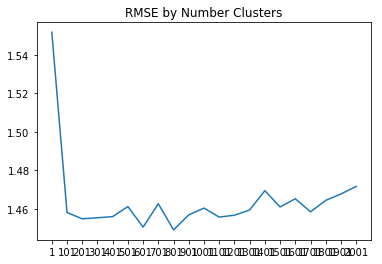

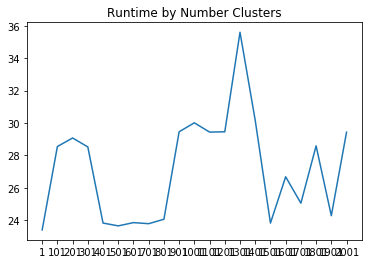

In [3]:
# Number of Clusters from 1 - 2002
df_ratings2 = df_ratings.sample(frac=1).copy()
df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(inplace=True, drop=True)

runtimes, rmses = [], []

df_books2 = df_books2[df_books2.NumberRatings > 1]     
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(drop=True, inplace=True)

user_ids_to_keep = []
for user in df_ratings2.User.unique():
    if len(df_ratings2[df_ratings2.User == user]) > 1:
        user_ids_to_keep.append(user)

df_ratings2 = df_ratings2[df_ratings2['User'].isin(user_ids_to_keep)]
df_books2 = df_books2[df_books2.ISBN.isin(df_ratings2.ISBN.unique())]
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(drop=True, inplace=True)

# X is the embedding representations of the blurbs
X = df_books2.iloc[:, 6:]
for cluster in range(1, 2002, 100):
    
    km = KMeans(n_clusters = cluster)
    clusters = km.fit_predict(X)
    df_books2["Cluster"] = clusters

    # Inserting a new column into df_ratings with the cluster for each rating
    cluster_list = []
    for isbn in range(len(df_ratings2)):
        cluster_list.append(df_books2.Cluster[df_books2.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
    df_ratings2['Cluster'] = cluster_list

    # Since I have clustered the books, there are now multiple ratings by the same user for the same
    # cluster. This screws up the SVD algorithm, so I find any block of repeated data and find the average
    # rating of each block and set the ratings to that average.
    cluster_dict = {}
    for user in df_ratings2.User.unique():
        user_df = df_ratings2[df_ratings2.User == user]
        cluster_dict[user] = {}
        for cluster in user_df.Cluster.unique():
            cluster_dict[user][cluster] = np.mean(user_df.Rating[user_df.Cluster == cluster])

    # averaged_by_cluster_ratings is our data but with averaged ratings for the repeated blocks.
    new_ratings = []
    for rating in range(len(df_ratings2)):
        new_ratings.append(cluster_dict[df_ratings2.iloc[rating, 0]][df_ratings2.iloc[rating, 3]])
    averaged_by_cluster_ratings = df_ratings2.copy()
    averaged_by_cluster_ratings['Rating'] = new_ratings

    reader = Reader(rating_scale=(1,10))
    avg_rmse = 0
    
    # If we evaluated on just averaged_by_cluster_ratings, we would be cheating since it is averaged data.
    # We want to train on averaged data for repeats, but evaluate on the original ratings.
    start = time.time()
    
    for cv in range(4):
        # test set is 1/10th of the non-averaged ratings 
        test_set = df_ratings2.sample(int(len(df_ratings2) * .15), replace=False)[['User', 'Cluster', 'Rating']]

        # train set is all of the ratings that are not in the test set and taken from the
        # non-averaged data.
        train_set = averaged_by_cluster_ratings[~averaged_by_cluster_ratings.index.isin(test_set.index)][['User', 'Cluster', 'Rating']]
        data = Dataset.load_from_df(train_set, reader)
        data = data.build_full_trainset()
        svd = SVD(n_factors=20, n_epochs=10)
        svd.fit(data)
        RMSE = 0
        for i in range(len(test_set)):
            uid = test_set.User.iloc[i]
            iid = test_set.Cluster.iloc[i]
            r_ui = test_set.Rating.iloc[i]
            pred = svd.predict(uid, iid, verbose=False)
            RMSE += (r_ui - pred[3]) ** 2
        avg_rmse += (RMSE / len(test_set)) ** 0.5
    rmses.append(avg_rmse/4)
    runtimes.append(time.time() - start)
    
plt.plot(rmses)
plt.title('RMSE by Number Clusters')
plt.xticks(range(21), range(1, 2002, 100))
plt.show()

plt.plot(runtimes)
plt.title('Runtime by Number Clusters')
plt.xticks(range(21), range(1, 2002, 100))
plt.show()

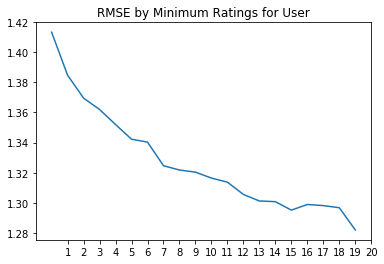

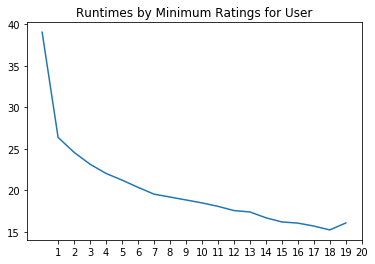

In [5]:
# Min ratings for user
num_clusters = 1000

df_ratings2 = df_ratings.sample(frac=1).copy()
df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]

runtimes, rmses = [], []

# Iterate by number of book clusters
for min_user_rating in range(20):
    
    user_ids_to_keep = []
    for user in df_ratings2.User.unique():
        if len(df_ratings2[df_ratings2.User == user]) > min_user_rating:
            user_ids_to_keep.append(user)
    df_ratings2 = df_ratings2[df_ratings2.User.isin(user_ids_to_keep)]
    
    df_books2 = df_books2[df_books2.ISBN.isin(df_ratings2.ISBN.unique())]
    df_books2.reset_index(drop=True, inplace=True)
    df_ratings2.reset_index(drop=True, inplace=True)
    
    # X is the embedding representations of the blurbs
    X = df_books2.iloc[:, 6:]

    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X)
    df_books2["Cluster"] = clusters
    
    # Inserting a new column into df_ratings with the cluster for each rating
    cluster_list = []
    for isbn in range(len(df_ratings2)):
        cluster_list.append(df_books2.Cluster[df_books2.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
    df_ratings2['Cluster'] = cluster_list
    
    # Since I have clustered the books, there are now multiple ratings by the same user for the same
    # cluster. This screws up the SVD algorithm, so I find any block of repeated data and find the average
    # rating of each block and set the ratings to that average.
    cluster_dict = {}
    for user in df_ratings2.User.unique():
        x = df_ratings2[df_ratings2.User == user]
        cluster_dict[user] = {}
        for cluster in x.Cluster.unique():
            cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

    # caveraged_by_cluster_ratings is our data but with averaged ratings for the repeated blocks.
    new_ratings = []
    for rating in range(len(df_ratings2)):
        new_ratings.append(cluster_dict[df_ratings2.iloc[rating, 0]][df_ratings2.iloc[rating, 3]])
    averaged_by_cluster_ratings = df_ratings2.copy()
    averaged_by_cluster_ratings['Rating'] = new_ratings
    
    reader = Reader(rating_scale=(1,10))
    avg_rmse = 0
    
    # If we evaluated on just averaged_by_cluster_ratings, we would be cheating since it is averaged data.
    # We want to train on averaged data for repeats, but evaluate on the original ratings.
    start = time.time()
    
    for cv in range(4):
        # test set is 1/10th of the non-averaged ratings 
        test_set = df_ratings2.sample(int(len(df_ratings2) * .15), replace=False)[['User', 'Cluster', 'Rating']]
        
        # train set is all of the ratings that are not in the test set and taken from the
        # non-averaged data.
        train_set = averaged_by_cluster_ratings[~averaged_by_cluster_ratings.index.isin(test_set.index)][['User', 'Cluster', 'Rating']]
        data = Dataset.load_from_df(train_set, reader)
        data = data.build_full_trainset()
        svd = SVD(n_factors=20, n_epochs=10)
        svd.fit(data)
        RMSE = 0
        for i in range(len(test_set)):
            uid = test_set.User.iloc[i]
            iid = test_set.Cluster.iloc[i]
            r_ui = test_set.Rating.iloc[i]
            pred = svd.predict(uid, iid, verbose=False)
            RMSE += (r_ui - pred[3]) ** 2
        avg_rmse += (RMSE / len(test_set)) ** 0.5
    rmses.append(avg_rmse/4)
    runtimes.append(time.time() - start)
    
plt.plot(rmses)
plt.title('RMSE by Minimum Ratings for User')
plt.xticks(range(1, 21), range(1, 21))
plt.show()

plt.plot(runtimes)
plt.title('Runtimes by Minimum Ratings for User')
plt.xticks(range(1, 21), range(1, 21))
plt.show()

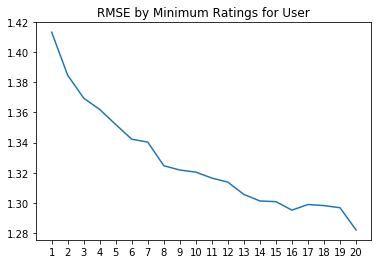

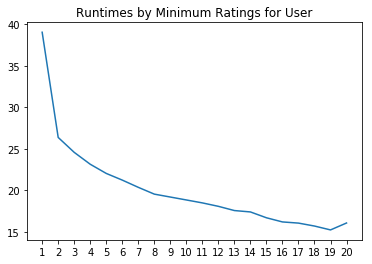

In [6]:
plt.plot(rmses)
plt.title('RMSE by Minimum Ratings for User')
plt.xticks(range(20), range(1, 21))
plt.show()

plt.plot(runtimes)
plt.title('Runtimes by Minimum Ratings for User')
plt.xticks(range(20), range(1, 21))
plt.show()

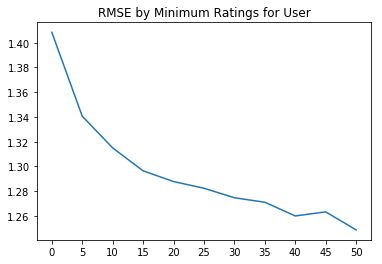

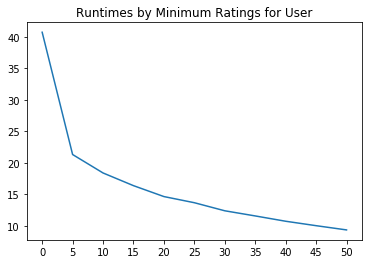

In [7]:
# Min ratings for user
num_clusters = 1000

df_ratings2 = df_ratings.sample(frac=1).copy()
df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]

runtimes, rmses = [], []

# Iterate by number of book clusters
for min_user_rating in range(0, 51, 5):
    
    user_ids_to_keep = []
    for user in df_ratings2.User.unique():
        if len(df_ratings2[df_ratings2.User == user]) > min_user_rating:
            user_ids_to_keep.append(user)
    df_ratings2 = df_ratings2[df_ratings2.User.isin(user_ids_to_keep)]
    
    df_books2 = df_books2[df_books2.ISBN.isin(df_ratings2.ISBN.unique())]
    df_books2.reset_index(drop=True, inplace=True)
    df_ratings2.reset_index(drop=True, inplace=True)
    
    # X is the embedding representations of the blurbs
    X = df_books2.iloc[:, 6:]

    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X)
    df_books2["Cluster"] = clusters
    
    # Inserting a new column into df_ratings with the cluster for each rating
    cluster_list = []
    for isbn in range(len(df_ratings2)):
        cluster_list.append(df_books2.Cluster[df_books2.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
    df_ratings2['Cluster'] = cluster_list
    
    # Since I have clustered the books, there are now multiple ratings by the same user for the same
    # cluster. This screws up the SVD algorithm, so I find any block of repeated data and find the average
    # rating of each block and set the ratings to that average.
    cluster_dict = {}
    for user in df_ratings2.User.unique():
        x = df_ratings2[df_ratings2.User == user]
        cluster_dict[user] = {}
        for cluster in x.Cluster.unique():
            cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

    # caveraged_by_cluster_ratings is our data but with averaged ratings for the repeated blocks.
    new_ratings = []
    for rating in range(len(df_ratings2)):
        new_ratings.append(cluster_dict[df_ratings2.iloc[rating, 0]][df_ratings2.iloc[rating, 3]])
    averaged_by_cluster_ratings = df_ratings2.copy()
    averaged_by_cluster_ratings['Rating'] = new_ratings
    
    reader = Reader(rating_scale=(1,10))
    avg_rmse = 0
    
    # If we evaluated on just averaged_by_cluster_ratings, we would be cheating since it is averaged data.
    # We want to train on averaged data for repeats, but evaluate on the original ratings.
    start = time.time()
    
    for cv in range(4):
        # test set is 1/10th of the non-averaged ratings 
        test_set = df_ratings2.sample(int(len(df_ratings2) * .15), replace=False)[['User', 'Cluster', 'Rating']]
        
        # train set is all of the ratings that are not in the test set and taken from the
        # non-averaged data.
        train_set = averaged_by_cluster_ratings[~averaged_by_cluster_ratings.index.isin(test_set.index)][['User', 'Cluster', 'Rating']]
        data = Dataset.load_from_df(train_set, reader)
        data = data.build_full_trainset()
        svd = SVD(n_factors=20, n_epochs=10)
        svd.fit(data)
        RMSE = 0
        for i in range(len(test_set)):
            uid = test_set.User.iloc[i]
            iid = test_set.Cluster.iloc[i]
            r_ui = test_set.Rating.iloc[i]
            pred = svd.predict(uid, iid, verbose=False)
            RMSE += (r_ui - pred[3]) ** 2
        avg_rmse += (RMSE / len(test_set)) ** 0.5
    rmses.append(avg_rmse/4)
    runtimes.append(time.time() - start)
    
plt.plot(rmses)
plt.title('RMSE by Minimum Ratings for User')
plt.xticks(range(11), range(0, 51, 5))
plt.show()

plt.plot(runtimes)
plt.title('Runtimes by Minimum Ratings for User')
plt.xticks(range(11), range(0, 51, 5))
plt.show()

In [ ]:
# Min ratings for books

num_cluster = 500

df_ratings2 = df_ratings.sample(frac=.1).copy()
df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]

runtimes, rmses = [], []

# Iterate by number of book clusters
for min_book_rating in range(10):
    
    isbns_to_keep = []
    for isbn in df_ratings2.ISBN.unique():
        if len(df_ratings2[df_ratings2.ISBN == isbn]) > min_book_rating:
            isbns_to_keep.append(isbn)
    df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(isbns_to_keep)]
    
    df_books2 = df_books2[df_books2.ISBN.isin(df_ratings2.ISBN.unique())]
    df_books2.reset_index(drop=True, inplace=True)
    df_ratings2.reset_index(drop=True, inplace=True)
    
    # X is the embedding representations of the blurbs
    X = df_books2.iloc[:, 6:]

    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X)
    df_books2["Cluster"] = clusters
    
    # Inserting a new column into df_ratings with the cluster for each rating
    cluster_list = []
    for isbn in range(len(df_ratings2)):
        cluster_list.append(df_books2.Cluster[df_books2.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
    df_ratings2['Cluster'] = cluster_list
    
    # Since I have clustered the books, there are now multiple ratings by the same user for the same
    # cluster. This screws up the SVD algorithm, so I find any block of repeated data and find the average
    # rating of each block and set the ratings to that average.
    cluster_dict = {}
    for user in df_ratings2.User.unique():
        x = df_ratings2[df_ratings2.User == user]
        cluster_dict[user] = {}
        for cluster in x.Cluster.unique():
            cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

    # caveraged_by_cluster_ratings is our data but with averaged ratings for the repeated blocks.
    new_ratings = []
    for rating in range(len(df_ratings2)):
        new_ratings.append(cluster_dict[df_ratings2.iloc[rating, 0]][df_ratings2.iloc[rating, 3]])
    averaged_by_cluster_ratings = df_ratings2.copy()
    averaged_by_cluster_ratings['Rating'] = new_ratings
    
    reader = Reader(rating_scale=(1,10))
    avg_rmse = 0
    
    # If we evaluated on just averaged_by_cluster_ratings, we would be cheating since it is averaged data.
    # We want to train on averaged data for repeats, but evaluate on the original ratings.
    start = time.time()
    for cv in range(4):
        # test set is 1/10th of the non-averaged ratings 
        test_set = df_ratings2.sample(int(len(df_ratings2) * .1), replace=False)[['User', 'Cluster', 'Rating']]
        
        # train set is all of the ratings that are not in the test set and taken from the
        # non-averaged data.
        train_set = averaged_by_cluster_ratings[~averaged_by_cluster_ratings.index.isin(test_set.index)][['User', 'Cluster', 'Rating']]
        data = Dataset.load_from_df(train_set, reader)
        data = data.build_full_trainset()
        svd = SVD(n_factors=50, n_epochs=15)
        svd.fit(data)
        RMSE = 0
        for i in range(len(test_set)):
            uid = test_set.User.iloc[i]
            iid = test_set.Cluster.iloc[i]
            r_ui = test_set.Rating.iloc[i]
            pred = svd.predict(uid, iid, verbose=False)
            RMSE += (r_ui - pred[3]) ** 2
        avg_rmse += (RMSE / len(test_set)) ** 0.5
    rmses.append(avg_rmse/4)
    runtimes.append(time.time() - start)
    
plt.plot(rmses)
plt.title('RMSE by Minimum Ratings for book')
plt.show()

plt.plot(runtimes)
plt.title('Runtimes by Minimum Ratings for book')
plt.show()

In [ ]:
# Factors

num_cluster = 500
min_user_rating = 5
min_book_rating = 5

df_ratings2 = df_ratings.sample(frac=.1).copy()
df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]

runtimes, rmses = [], []

# Iterate by number of book clusters
for num_factors in range(1, 502, 50):
    
    isbns_to_keep = []
    for isbn in df_ratings2.ISBN.unique():
        if len(df_ratings2[df_ratings2.ISBN == isbn]) > min_book_rating:
            isbns_to_keep.append(isbn)
    df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(isbns_to_keep)]
    
    df_books2 = df_books2[df_books2.ISBN.isin(df_ratings2.ISBN.unique())]
    df_books2.reset_index(drop=True, inplace=True)
    df_ratings2.reset_index(drop=True, inplace=True)
    
    user_ids_to_keep = []
    for user in df_ratings2.User.unique():
        if len(df_ratings2[df_ratings2.User == user]) > min_user_rating:
            user_ids_to_keep.append(user)
    df_ratings2 = df_ratings2[df_ratings2.User.isin(user_ids_to_keep)]
    
    df_books2 = df_books2[df_books2.ISBN.isin(df_ratings2.ISBN.unique())]
    df_books2.reset_index(drop=True, inplace=True)
    df_ratings2.reset_index(drop=True, inplace=True)
    
    # X is the embedding representations of the blurbs
    X = df_books2.iloc[:, 6:]

    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X)
    df_books2["Cluster"] = clusters
    
    # Inserting a new column into df_ratings with the cluster for each rating
    cluster_list = []
    for isbn in range(len(df_ratings2)):
        cluster_list.append(df_books2.Cluster[df_books2.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
    df_ratings2['Cluster'] = cluster_list
    
    # Since I have clustered the books, there are now multiple ratings by the same user for the same
    # cluster. This screws up the SVD algorithm, so I find any block of repeated data and find the average
    # rating of each block and set the ratings to that average.
    cluster_dict = {}
    for user in df_ratings2.User.unique():
        x = df_ratings2[df_ratings2.User == user]
        cluster_dict[user] = {}
        for cluster in x.Cluster.unique():
            cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

    # caveraged_by_cluster_ratings is our data but with averaged ratings for the repeated blocks.
    new_ratings = []
    for rating in range(len(df_ratings2)):
        new_ratings.append(cluster_dict[df_ratings2.iloc[rating, 0]][df_ratings2.iloc[rating, 3]])
    averaged_by_cluster_ratings = df_ratings2.copy()
    averaged_by_cluster_ratings['Rating'] = new_ratings
    
    reader = Reader(rating_scale=(1,10))
    avg_rmse = 0
    
    # If we evaluated on just averaged_by_cluster_ratings, we would be cheating since it is averaged data.
    # We want to train on averaged data for repeats, but evaluate on the original ratings.
    start = time.time()
    for cv in range(4):
        # test set is 1/10th of the non-averaged ratings 
        test_set = df_ratings2.sample(int(len(df_ratings2) * .1), replace=False)[['User', 'Cluster', 'Rating']]
        
        # train set is all of the ratings that are not in the test set and taken from the
        # non-averaged data.
        train_set = averaged_by_cluster_ratings[~averaged_by_cluster_ratings.index.isin(test_set.index)][['User', 'Cluster', 'Rating']]
        data = Dataset.load_from_df(train_set, reader)
        data = data.build_full_trainset()
        svd = SVD(n_factors=num_factors, n_epochs=15)
        svd.fit(data)
        RMSE = 0
        for i in range(len(test_set)):
            uid = test_set.User.iloc[i]
            iid = test_set.Cluster.iloc[i]
            r_ui = test_set.Rating.iloc[i]
            pred = svd.predict(uid, iid, verbose=False)
            RMSE += (r_ui - pred[3]) ** 2
        avg_rmse += (RMSE / len(test_set)) ** 0.5
    rmses.append(avg_rmse/4)
    runtimes.append(time.time() - start)
    
plt.plot(rmses)
plt.title('RMSE by Number of Factors')
plt.xticks(range(11), range(1, 502, 50))
plt.show()

plt.plot(runtimes)
plt.title('Runtimes by Number of Factors')
plt.xticks(range(11), range(1, 502, 50))
plt.show()

In [ ]:
# Epochs

num_cluster = 500
min_user_rating = 5
min_book_rating = 5
num_factors = 100

df_ratings2 = df_ratings.sample(frac=.1).copy()
df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]

runtimes, rmses = [], []

# Iterate by number of book clusters
for epochs in range(1, 42, 5):
    
    isbns_to_keep = []
    for isbn in df_ratings2.ISBN.unique():
        if len(df_ratings2[df_ratings2.ISBN == isbn]) > min_book_rating:
            isbns_to_keep.append(isbn)
    df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(isbns_to_keep)]
    
    df_books2 = df_books2[df_books2.ISBN.isin(df_ratings2.ISBN.unique())]
    df_books2.reset_index(drop=True, inplace=True)
    df_ratings2.reset_index(drop=True, inplace=True)
    
    user_ids_to_keep = []
    for user in df_ratings2.User.unique():
        if len(df_ratings2[df_ratings2.User == user]) > min_user_rating:
            user_ids_to_keep.append(user)
    df_ratings2 = df_ratings2[df_ratings2.User.isin(user_ids_to_keep)]
    
    df_books2 = df_books2[df_books2.ISBN.isin(df_ratings2.ISBN.unique())]
    df_books2.reset_index(drop=True, inplace=True)
    df_ratings2.reset_index(drop=True, inplace=True)
    
    # X is the embedding representations of the blurbs
    X = df_books2.iloc[:, 6:]

    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X)
    df_books2["Cluster"] = clusters
    
    # Inserting a new column into df_ratings with the cluster for each rating
    cluster_list = []
    for isbn in range(len(df_ratings2)):
        cluster_list.append(df_books2.Cluster[df_books2.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
    df_ratings2['Cluster'] = cluster_list
    
    # Since I have clustered the books, there are now multiple ratings by the same user for the same
    # cluster. This screws up the SVD algorithm, so I find any block of repeated data and find the average
    # rating of each block and set the ratings to that average.
    cluster_dict = {}
    for user in df_ratings2.User.unique():
        x = df_ratings2[df_ratings2.User == user]
        cluster_dict[user] = {}
        for cluster in x.Cluster.unique():
            cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

    # caveraged_by_cluster_ratings is our data but with averaged ratings for the repeated blocks.
    new_ratings = []
    for rating in range(len(df_ratings2)):
        new_ratings.append(cluster_dict[df_ratings2.iloc[rating, 0]][df_ratings2.iloc[rating, 3]])
    averaged_by_cluster_ratings = df_ratings2.copy()
    averaged_by_cluster_ratings['Rating'] = new_ratings
    
    reader = Reader(rating_scale=(1,10))
    avg_rmse = 0
    
    # If we evaluated on just averaged_by_cluster_ratings, we would be cheating since it is averaged data.
    # We want to train on averaged data for repeats, but evaluate on the original ratings.
    start = time.time()
    for cv in range(4):
        # test set is 1/10th of the non-averaged ratings 
        test_set = df_ratings2.sample(int(len(df_ratings2) * .1), replace=False)[['User', 'Cluster', 'Rating']]
        
        # train set is all of the ratings that are not in the test set and taken from the
        # non-averaged data.
        train_set = averaged_by_cluster_ratings[~averaged_by_cluster_ratings.index.isin(test_set.index)][['User', 'Cluster', 'Rating']]
        data = Dataset.load_from_df(train_set, reader)
        data = data.build_full_trainset()
        svd = SVD(n_factors=num_factors, n_epochs=epochs)
        svd.fit(data)
        RMSE = 0
        for i in range(len(test_set)):
            uid = test_set.User.iloc[i]
            iid = test_set.Cluster.iloc[i]
            r_ui = test_set.Rating.iloc[i]
            pred = svd.predict(uid, iid, verbose=False)
            RMSE += (r_ui - pred[3]) ** 2
        avg_rmse += (RMSE / len(test_set)) ** 0.5
    rmses.append(avg_rmse/4)
    runtimes.append(time.time() - start)
    
plt.plot(rmses)
plt.title('RMSE by Number of Factors')
plt.xticks(range(9), range(1, 42, 5))
plt.show()

plt.plot(runtimes)
plt.title('Runtimes by Number of Factors')
plt.xticks(range(9), range(1, 42, 5))
plt.show()

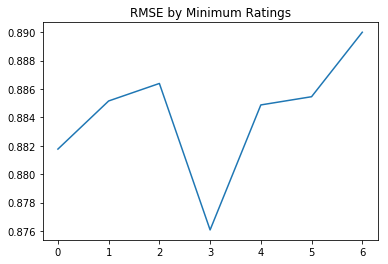

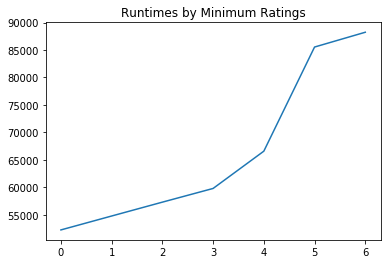

In [83]:
# By number of Min Ratings. In theory, users with small amounts of ratings are not adding additional
# information for the algorithm to learn. Here, I try cutting out users with small amounts of ratings
# to see if it improves our model. Cutting out users has the additional advantage of improving speed.

user_ids_to_keep = []

# From the above graph, it appears that the optimal number of clusters is beyond the limit I tested. For now,
# I will test other parameters with 250 clusters.

num_clusters = 250
runtimes, rmses = [], []

for min_rating in range(1, 14, 2):
    
    start = time.time()
    
    for user in df_ratings.User.unique():
        if len(df_ratings[df_ratings.User == user]) > min_user_rating:
            user_ids_to_keep.append(user)

    df_ratings2 = df_ratings[df_ratings['User'].isin(user_ids_to_keep)].copy()

    df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
    df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
    df_books2.reset_index(drop=True, inplace=True)
    df_ratings2.reset_index(drop=True, inplace=True)

    X = df_books2.iloc[:, 6:]

    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X)
    isbns = list(df_books2.ISBN)
    cluster_df = pd.DataFrame()
    cluster_df['ISBN'] = isbns
    cluster_df['Cluster'] = clusters
    
    cluster_list = []
    for isbn in range(len(df_ratings2)):
        cluster_list.append(cluster_df.Cluster[cluster_df.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
    df_ratings2['Cluster'] = cluster_list
    
    clustered_ratings = pd.DataFrame()
    clustered_ratings['User'] = df_ratings2.User
    clustered_ratings['Cluster'] = df_ratings2.Cluster
    clustered_ratings['Rating'] = df_ratings2.Rating
    
    cluster_dict = {}
    for user in clustered_ratings.User.unique():
        x = clustered_ratings[clustered_ratings.User == user]
        cluster_dict[user] = {}
        for cluster in x.Cluster.unique():
            cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

    new_ratings = []
    for rating in range(len(clustered_ratings)):
        new_ratings.append(cluster_dict[clustered_ratings.iloc[rating, 0]][clustered_ratings.iloc[rating, 1]])
    clustered_ratings2 = clustered_ratings.copy()
    clustered_ratings2['Rating'] = new_ratings
    
    reader = Reader(rating_scale=(1,10))
    
    avg_rmse = 0
    for cv in range(4):
        test_set = clustered_ratings.sample(int(len(clustered_ratings) * .1), replace=False)
        train_set = clustered_ratings2[~clustered_ratings2.index.isin(test_set.index)].dropna()
        data = Dataset.load_from_df(train_set, reader)
        x = data.build_full_trainset()
        svd = SVD(n_factors=20, n_epochs=10)
        svd.fit(x)
        RMSE = 0
        for i in range(len(test_set)):
            uid = test_set.User.iloc[i]
            iid = test_set.Cluster.iloc[i]
            r_ui = test_set.Rating.iloc[i]
            pred = svd.predict(uid, iid, verbose=False)
            RMSE += (r_ui - pred[3]) ** 2
        avg_rmse += (RMSE / len(test_set)) ** 0.5
    rmses.append(avg_rmse/4)
    runtimes.append(time.time() - start)
    
plt.plot(rmses)
plt.title('RMSE by Minimum Ratings')
plt.show()

plt.plot(runtimes)
plt.title('Runtimes by Minimum Ratings')
plt.show()
    

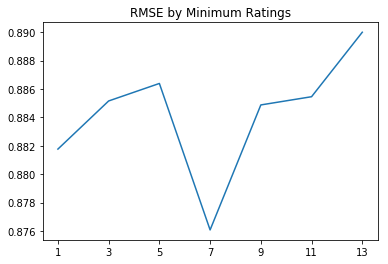

In [86]:
# This is the correct xticks for the above graph

plt.plot(rmses)
plt.title('RMSE by Minimum Ratings')
plt.xticks(range(7), range(1, 14, 2))
plt.show()

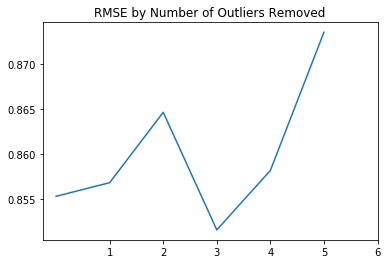

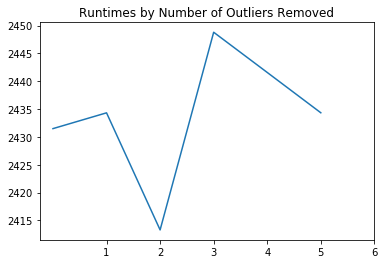

In [93]:
## By Max Ratings.
# As seen in the EDA notebook, there are some users in the dataset with a suspiciously large amount of ratings.
# Almost 7,000 ratings in one case. The distributions of their ratings do not match the overall distribution
# in some cases. In this cell I see if cutting out some of the top raters improves the algorithm.

user_ids_to_keep = []
min_user_rating = 7
num_clusters = 250
runtimes, rmses = [], []

user_num_ratings, reverse = {}, {}
for user in df_ratings.User.unique():
    length = len(df_ratings[df_ratings.User == user])
    if length > 800:
        user_num_ratings[user] = length
        reverse[length] = user
tops = []
for most_raters in range(6):
    tops.append(reverse[max(user_num_ratings.values())])
    user_num_ratings[tops[-1]] = -1
    
# tops now contains the userids of the top 6 raters.
    
for max_ratings in range(len(tops)):
    
    start = time.time()
    
    user_num_ratings = {}
    for user in df_ratings.User.unique():
        if (len(df_ratings[df_ratings.User == user]) > min_user_rating) and (user not in tops[:(max_ratings + 1)]):
            user_ids_to_keep.append(user)

    df_ratings2 = df_ratings[df_ratings['User'].isin(user_ids_to_keep)].copy()

    df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
    df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
    df_books2.reset_index(drop=True, inplace=True)
    df_ratings2.reset_index(drop=True, inplace=True)

    X = df_books2.iloc[:, 6:]

    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X)
    isbns = list(df_books2.ISBN)
    cluster_df = pd.DataFrame()
    cluster_df['ISBN'] = isbns
    cluster_df['Cluster'] = clusters
    
    cluster_list = []
    for isbn in range(len(df_ratings2)):
        cluster_list.append(cluster_df.Cluster[cluster_df.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
    df_ratings2['Cluster'] = cluster_list
    
    clustered_ratings = pd.DataFrame()
    clustered_ratings['User'] = df_ratings2.User
    clustered_ratings['Cluster'] = df_ratings2.Cluster
    clustered_ratings['Rating'] = df_ratings2.Rating
    
    cluster_dict = {}
    for user in clustered_ratings.User.unique():
        x = clustered_ratings[clustered_ratings.User == user]
        cluster_dict[user] = {}
        for cluster in x.Cluster.unique():
            cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

    new_ratings = []
    for rating in range(len(clustered_ratings)):
        new_ratings.append(cluster_dict[clustered_ratings.iloc[rating, 0]][clustered_ratings.iloc[rating, 1]])
    clustered_ratings2 = clustered_ratings.copy()
    clustered_ratings2['Rating'] = new_ratings
    
    reader = Reader(rating_scale=(1,10))
    avg_rmse = 0
    
    for cv in range(4):
        test_set = clustered_ratings.sample(int(len(clustered_ratings) * .1), replace=False)
        test_set.reset_index(drop=True, inplace=True)
        train_set = clustered_ratings2[~clustered_ratings2.isin(test_set)].dropna()
        data = Dataset.load_from_df(train_set, reader)
        svd = SVD(n_factors=20, n_epochs=10)
        x = data.build_full_trainset()
        svd.fit(x)
        RMSE = 0
        for i in range(len(test_set)):
            uid = test_set.User.iloc[i]
            iid = test_set.Cluster.iloc[i]
            r_ui = test_set.Rating.iloc[i]
            pred = svd.predict(uid, iid, verbose=False)
            RMSE += (r_ui - pred[3]) ** 2
        avg_rmse += (RMSE / len(test_set)) ** 0.5
    rmses.append(avg_rmse/4)
    runtimes.append(time.time() - start)
    
plt.plot(rmses)
plt.title('RMSE by Number of Outliers Removed')
plt.xticks(range(1,7))
plt.show()

plt.plot(runtimes)
plt.title('Runtimes by Number of Outliers Removed')
plt.xticks(range(1,7))
plt.show()
    

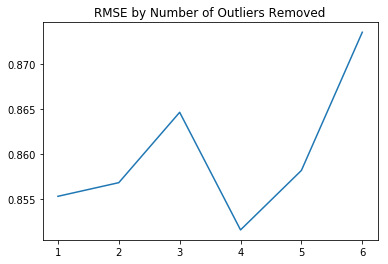

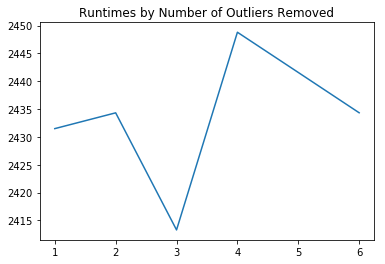

In [97]:
# Correct xticks
plt.plot(rmses)
plt.title('RMSE by Number of Outliers Removed')
plt.xticks(range(6), range(1,7))
plt.show()

plt.plot(runtimes)
plt.title('Runtimes by Number of Outliers Removed')
plt.xticks(range(6), range(1,7))
plt.show()

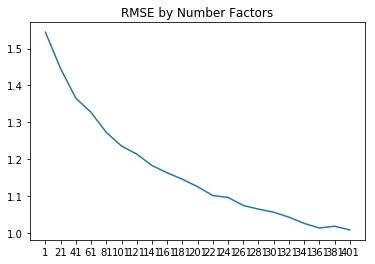

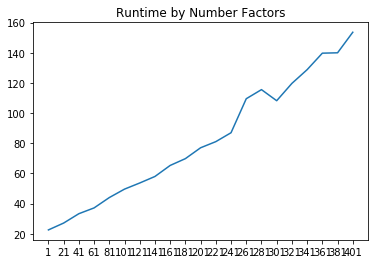

In [99]:
# By number of factors in SVD algorithm

start = time.time()
df_books = pd.read_csv('/DataScience/Final Capstone Files/books_with_blurbs_and_BERT_combined.csv')
df_books.drop('Unnamed: 0', 1, inplace=True)

df_ratings = pd.read_csv('/DataScience/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding = "latin-1")
df_ratings.rename(columns={'User-ID': 'User', 'Book-Rating': 'Rating'}, inplace=True)
df_ratings = df_ratings[df_ratings['Rating'] > 0]

num_outliers = 4
min_user_rating = 7
num_clusters = 250
rmses, runtimes = [], []

user_ids_to_keep = []
for user in df_ratings.User.unique():
    if (len(df_ratings[df_ratings.User == user]) > min_user_rating) and (user not in tops[:num_outliers]):
        user_ids_to_keep.append(user)

df_ratings2 = df_ratings[df_ratings['User'].isin(user_ids_to_keep)].copy()

df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(drop=True, inplace=True)

X = df_books2.iloc[:, 6:]

km = KMeans(n_clusters = num_clusters)
clusters = km.fit_predict(X)
isbns = list(df_books2.ISBN)
cluster_df = pd.DataFrame()
cluster_df['ISBN'] = isbns
cluster_df['Cluster'] = clusters

cluster_list = []
for isbn in range(len(df_ratings2)):
    cluster_list.append(cluster_df.Cluster[cluster_df.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
df_ratings2['Cluster'] = cluster_list

clustered_ratings = pd.DataFrame()
clustered_ratings['User'] = df_ratings2.User
clustered_ratings['Cluster'] = df_ratings2.Cluster
clustered_ratings['Rating'] = df_ratings2.Rating

cluster_dict = {}
for user in clustered_ratings.User.unique():
    x = clustered_ratings[clustered_ratings.User == user]
    cluster_dict[user] = {}
    for cluster in x.Cluster.unique():
        cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])
new_ratings = []
for rating in range(len(clustered_ratings)):
    new_ratings.append(cluster_dict[clustered_ratings.iloc[rating, 0]][clustered_ratings.iloc[rating, 1]])
clustered_ratings2 = clustered_ratings.copy()
clustered_ratings2['Rating'] = new_ratings

for n_factors in range(1, 402, 20):

    start = time.time()
    reader = Reader(rating_scale=(1,10))
    svd = SVD(n_factors=n_factors, n_epochs=10)
    avg_rmse = 0
    for cv in range(4):
        test_set = clustered_ratings.sample(int(len(clustered_ratings) * .1), replace=False)
        test_set.reset_index(drop=True, inplace=True)
        train_set = clustered_ratings2[~clustered_ratings2.isin(test_set)].dropna()
        data = Dataset.load_from_df(train_set, reader)
        x = data.build_full_trainset()
        svd.fit(x)
        RMSE = 0
        for i in range(len(test_set)):
            uid = test_set.User.iloc[i]
            iid = test_set.Cluster.iloc[i]
            r_ui = test_set.Rating.iloc[i]
            pred = svd.predict(uid, iid, verbose=False)
            RMSE += (r_ui - pred[3]) ** 2
        avg_rmse += (RMSE / len(test_set)) ** 0.5
    
    rmses.append(avg_rmse/4)
    runtimes.append(time.time() - start)


plt.plot(rmses)
plt.title('RMSE by Number Factors')
plt.xticks(range(21), range(1, 402, 20))
plt.show()
    
plt.plot(runtimes)
plt.title('Runtime by Number Factors')
plt.xticks(range(21), range(1, 402, 20))
plt.show()

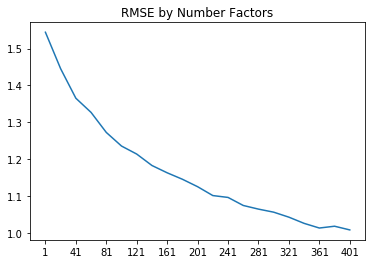

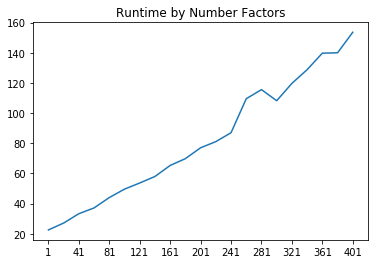

In [100]:
plt.plot(rmses)
plt.title('RMSE by Number Factors')
plt.xticks(range(0, 21, 2), range(1, 402, 40))
plt.show()
    
plt.plot(runtimes)
plt.title('Runtime by Number Factors')
plt.xticks(range(0, 21, 2), range(1, 402, 40))
plt.show()

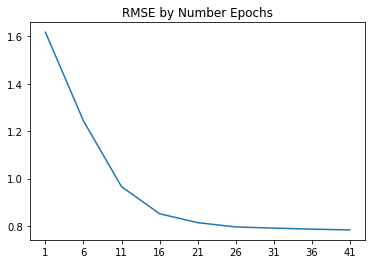

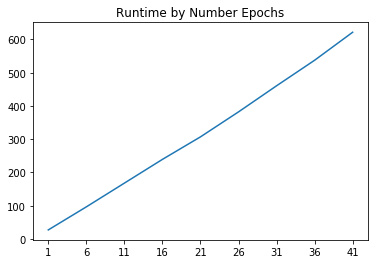

In [101]:
# Epochs

reader = Reader(rating_scale=(1,10))
rmses = []
runtimes = []
for epochs in range(1, 42, 5):

    start = time.time()
    svd = SVD(n_factors=400, n_epochs=epochs)
    avg_rmse = 0
    for cv in range(4):
        test_set = clustered_ratings.sample(int(len(clustered_ratings) * .1), replace=False)
        test_set.reset_index(drop=True, inplace=True)
        train_set = clustered_ratings2[~clustered_ratings2.isin(test_set)].dropna()
        data = Dataset.load_from_df(train_set, reader)
        x = data.build_full_trainset()
        svd.fit(x)
        RMSE = 0
        for i in range(len(test_set)):
            uid = test_set.User.iloc[i]
            iid = test_set.Cluster.iloc[i]
            r_ui = test_set.Rating.iloc[i]
            pred = svd.predict(uid, iid, verbose=False)
            RMSE += (r_ui - pred[3]) ** 2
        avg_rmse += (RMSE / len(test_set)) ** 0.5
    rmses.append(avg_rmse/4)
    runtimes.append(time.time() - start)
    
plt.plot(rmses)
plt.title('RMSE by Number Epochs')
plt.xticks(range(9), range(1, 42, 5))
plt.show()

plt.plot(runtimes)
plt.title('Runtime by Number Epochs')
plt.xticks(range(9), range(1, 42, 5))
plt.show()


In [3]:
## Final High Performance Model
start = time.time()

min_user_rating = 7
num_clusters = 500
cross_vals = 10
num_outliers = 4
num_epochs = 30
num_factors = 500

runtimes, rmses, user_ids_to_keep = [], [], []

user_num_ratings, reverse = {}, {}
for user in df_ratings.User.unique():
    length = len(df_ratings[df_ratings.User == user])
    if length > 800:
        user_num_ratings[user] = length
        reverse[length] = user
tops = []
for most_raters in range(6):
    tops.append(reverse[max(user_num_ratings.values())])
    user_num_ratings[tops[-1]] = -1

for user in df_ratings.User.unique():
    if (len(df_ratings[df_ratings.User == user]) > min_user_rating) and (user not in tops[:(num_outliers + 1)]):
        user_ids_to_keep.append(user)

df_ratings2 = df_ratings[df_ratings['User'].isin(user_ids_to_keep)].copy()

df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(drop=True, inplace=True)

X = df_books2.iloc[:, 6:]

km = KMeans(n_clusters = num_clusters)
clusters = km.fit_predict(X)
isbns = list(df_books2.ISBN)
cluster_df = pd.DataFrame()
cluster_df['ISBN'] = isbns
cluster_df['Cluster'] = clusters

cluster_list = []
for isbn in range(len(df_ratings2)):
    cluster_list.append(cluster_df.Cluster[cluster_df.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
df_ratings2['Cluster'] = cluster_list

clustered_ratings = pd.DataFrame()
clustered_ratings['User'] = df_ratings2.User
clustered_ratings['Cluster'] = df_ratings2.Cluster
clustered_ratings['Rating'] = df_ratings2.Rating

cluster_dict = {}
for user in clustered_ratings.User.unique():
    x = clustered_ratings[clustered_ratings.User == user]
    cluster_dict[user] = {}
    for cluster in x.Cluster.unique():
        cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

new_ratings = []
for rating in range(len(clustered_ratings)):
    new_ratings.append(cluster_dict[clustered_ratings.iloc[rating, 0]][clustered_ratings.iloc[rating, 1]])
clustered_ratings2 = clustered_ratings.copy()
clustered_ratings2['Rating'] = new_ratings

reader = Reader(rating_scale=(1,10))
avg_rmse = 0

for cv in range(cross_vals):
    svd = SVD(n_factors=num_factors, n_epochs=num_epochs)
    test_set = clustered_ratings.iloc[(cv * len(clustered_ratings) // cross_vals) : ((cv + 1) * len(clustered_ratings) // cross_vals)]
    test_set.reset_index(drop=True, inplace=True)
    train_set = clustered_ratings2[~clustered_ratings2.isin(test_set)].dropna()
    data = Dataset.load_from_df(train_set, reader)
    x = data.build_full_trainset()
    svd.fit(x)
    RMSE = 0
    for i in range(len(test_set)):
        uid = test_set.User.iloc[i]
        iid = test_set.Cluster.iloc[i]
        r_ui = test_set.Rating.iloc[i]
        pred = svd.predict(uid, iid, verbose=False)
        RMSE += (r_ui - pred[3]) ** 2
    avg_rmse += (RMSE / len(test_set)) ** 0.5
    
print('RMSE with {}-fold cross validation:'.format(cross_vals), avg_rmse/cross_vals)
print('\n', 'Runtime:', time.time() - start)

svd = SVD(n_factors=num_factors, n_epochs=num_epochs)
cross_validate(svd, clustered_ratings2, ['RMSE'], cv=4, verbose=True)

df_ratings2.to_csv('/DataScience/Final Capstone Files/PerformanceRatingsWithClusters.csv', index=False)
df_books2.to_csv('/DataScience/Final Capstone Files/PerformanceBooks.csv', index=False)
    

RMSE with 10-fold cross validation: 0.7590980521011454

 Runtime: 4977.248323917389


AttributeError: 'DataFrame' object has no attribute 'raw_ratings'

In [29]:
reader = Reader(rating_scale=(1,10))
avg_rmse = 0

for cv in range(cross_vals):
    svd = SVD(n_factors=num_factors, n_epochs=num_epochs)
    test_set = clustered_ratings.iloc[(cv * len(clustered_ratings) // cross_vals) : ((cv + 1) * len(clustered_ratings) // cross_vals)]
    test_set.reset_index(drop=True, inplace=True)
    train_set = clustered_ratings2[~clustered_ratings2.isin(test_set)].dropna()
    data = Dataset.load_from_df(train_set, reader)
    x = data.build_full_trainset()
    svd.fit(x)
    RMSE = 0
    for i in range(len(test_set)):
        uid = test_set.User.iloc[i]
        iid = test_set.Cluster.iloc[i]
        r_ui = test_set.Rating.iloc[i]
        pred = svd.predict(uid, iid, verbose=False)
        RMSE += (r_ui - pred[3]) ** 2
    print((RMSE / len(test_set)) ** 0.5)
    avg_rmse += (RMSE / len(test_set)) ** 0.5
    
print('RMSE with {}-fold cross validation:'.format(cross_vals), avg_rmse/cross_vals)
print('\n', 'Runtime:', time.time() - start)


1.7843644949505706


KeyboardInterrupt: 

In [28]:
cross_vals

10

In [20]:
test_set = clustered_ratings.iloc[(cv * len(clustered_ratings) // cross_vals) : ((cv + 1) * len(clustered_ratings) // cross_vals)]
train_set = clustered_ratings2[~clustered_ratings2.index.isin(test_set.index)].dropna()

In [27]:
start = time.time()
avg_rmse = 0

for cv in range(cross_vals):
    svd = SVD(n_factors=num_factors, n_epochs=num_epochs)
    test_set = clustered_ratings.iloc[(cv * len(clustered_ratings) // cross_vals) : ((cv + 1) * len(clustered_ratings) // cross_vals)]
    train_set = clustered_ratings2[~clustered_ratings2.index.isin(test_set.index)].dropna()
    data = Dataset.load_from_df(train_set, reader)
    x = data.build_full_trainset()
    svd.fit(x)
    RMSE = 0
    for i in range(len(test_set)):
        uid = test_set.User.iloc[i]
        iid = test_set.Cluster.iloc[i]
        r_ui = test_set.Rating.iloc[i]
        pred = svd.predict(uid, iid, verbose=False)
        RMSE += (r_ui - pred[3]) ** 2
    avg_rmse += (RMSE / len(test_set)) ** 0.5

print('RMSE with {}-fold cross validation:'.format(cross_vals), avg_rmse/cross_vals)
print('\n', 'Runtime:', time.time() - start)

RMSE with 10-fold cross validation: 1.79216111386206

 Runtime: 1450.6110050678253


In [26]:
avg_rmse/cross_vals

2.5513279360904906

In [23]:
165216 + 18358

183574

In [4]:
# Whoops! Fixing the above error without having to re-run the whole cell since the runtime is very long.
svd = SVD(n_factors=num_factors, n_epochs=num_epochs)
data = Dataset.load_from_df(clustered_ratings2, reader)
cross_validate(svd, data, ['RMSE'], cv=4, verbose=True)

Evaluating RMSE of algorithm SVD on 4 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Mean    Std     
RMSE (testset)    1.4320  1.4147  1.4197  1.4304  1.4242  0.0072  
Fit time          98.96   101.97  118.57  117.34  109.21  8.82    
Test time         0.98    0.71    0.71    1.69    1.02    0.40    


{'test_rmse': array([1.43195127, 1.41472038, 1.41971588, 1.43044413]),
 'fit_time': (98.96440505981445,
  101.96657609939575,
  118.57480716705322,
  117.3438630104065),
 'test_time': (0.9770188331604004,
  0.7128982543945312,
  0.7065761089324951,
  1.6926679611206055)}

In [135]:
## Final Fast Model

start = time.time()

min_user_rating = 20
num_clusters = 100
cross_vals = 10
num_outliers = 6
num_factors = 100
num_epochs = 10

runtimes, rmses, user_ids_to_keep = [], [], []

user_num_ratings, reverse = {}, {}
for user in df_ratings.User.unique():
    length = len(df_ratings[df_ratings.User == user])
    if length > 800:
        user_num_ratings[user] = length
        reverse[length] = user
tops = []
for most_raters in range(6):
    tops.append(reverse[max(user_num_ratings.values())])
    user_num_ratings[tops[-1]] = -1

for user in df_ratings.User.unique():
    if (len(df_ratings[df_ratings.User == user]) > min_user_rating) and (user not in tops[:(num_outliers + 1)]):
        user_ids_to_keep.append(user)

df_ratings2 = df_ratings[df_ratings['User'].isin(user_ids_to_keep)].copy()

df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(drop=True, inplace=True)

X = df_books2.iloc[:, 6:]

km = KMeans(n_clusters = num_clusters)
clusters = km.fit_predict(X)
isbns = list(df_books2.ISBN)
cluster_df = pd.DataFrame()
cluster_df['ISBN'] = isbns
cluster_df['Cluster'] = clusters

cluster_list = []
for isbn in range(len(df_ratings2)):
    cluster_list.append(cluster_df.Cluster[cluster_df.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
df_ratings2['Cluster'] = cluster_list

clustered_ratings = pd.DataFrame()
clustered_ratings['User'] = df_ratings2.User
clustered_ratings['Cluster'] = df_ratings2.Cluster
clustered_ratings['Rating'] = df_ratings2.Rating

cluster_dict = {}
for user in clustered_ratings.User.unique():
    x = clustered_ratings[clustered_ratings.User == user]
    cluster_dict[user] = {}
    for cluster in x.Cluster.unique():
        cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

new_ratings = []
for rating in range(len(clustered_ratings)):
    new_ratings.append(cluster_dict[clustered_ratings.iloc[rating, 0]][clustered_ratings.iloc[rating, 1]])
clustered_ratings2 = clustered_ratings.copy()
clustered_ratings2['Rating'] = new_ratings

reader = Reader(rating_scale=(1,10))
avg_rmse = 0

for cv in range(cross_vals):
    svd = SVD(n_factors=num_factors, n_epochs=num_epochs)
    test_set = clustered_ratings.iloc[(cv * len(clustered_ratings) // cross_vals) : ((cv + 1) * len(clustered_ratings) // cross_vals)]
    test_set.reset_index(drop=True, inplace=True)
    train_set = clustered_ratings2[~clustered_ratings2.isin(test_set)].dropna()
    data = Dataset.load_from_df(train_set, reader)
    x = data.build_full_trainset()
    svd.fit(x)
    RMSE = 0
    for i in range(len(test_set)):
        uid = test_set.User.iloc[i]
        iid = test_set.Cluster.iloc[i]
        r_ui = test_set.Rating.iloc[i]
        pred = svd.predict(uid, iid, verbose=False)
        RMSE += (r_ui - pred[3]) ** 2
    avg_rmse += (RMSE / len(test_set)) ** 0.5
    
print('RMSE with {}-fold cross validation:'.format(cross_vals), avg_rmse/cross_vals)
print('\n', 'Runtime:', time.time() - start)   

df_ratings2.to_csv('/DataScience/Final Capstone Files/FastRatingsWithClusters.csv', index=False)
df_books2.to_csv('/DataScience/Final Capstone Files/FastBooks.csv', index=False)

RMSE with 10-fold cross validation: 1.320841256471648

 Runtime: 1694.7013149261475


In [141]:
# Calculating runtime with ideal parameters for speed and checking runtime

cross_vals = 1
start = time.time()
reader = Reader(rating_scale=(1,10))
avg_rmse = 0
num_factors = 50
num_epochs = 15

svd = SVD(n_factors=num_factors, n_epochs=num_epochs)
test_set = clustered_ratings.sample(frac=.1)
test_set.reset_index(drop=True, inplace=True)
train_set = clustered_ratings2[~clustered_ratings2.isin(test_set)].dropna()
data = Dataset.load_from_df(train_set, reader)
x = data.build_full_trainset()
svd.fit(x)
print('Runtime:', time.time() - start)   
RMSE = 0
for i in range(len(test_set)):
    uid = test_set.User.iloc[i]
    iid = test_set.Cluster.iloc[i]
    r_ui = test_set.Rating.iloc[i]
    pred = svd.predict(uid, iid, verbose=False)
    RMSE += (r_ui - pred[3]) ** 2
RMSE = (RMSE / len(test_set)) ** 0.5
    
print('RMSE', RMSE)   

Runtime: 4.880927801132202
RMSE 1.2223950374891799


In [ ]:
# In order to reduce the amount of active RAM required for implementation, the next two
# cells save csv files of the dataframes for speed and performance to be used in implementation

In [19]:
# Set up popularity df dataframe for Speed

df_books = pd.read_csv('/DataScience/Final Capstone Files/books_with_blurbs_and_BERT_combined.csv')
df_books.drop('Unnamed: 0', 1, inplace=True)

df_ratings = pd.read_csv('/DataScience/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding = "latin-1")
df_ratings.rename(columns={'User-ID': 'User', 'Book-Rating': 'Rating'}, inplace=True)
df_ratings = df_ratings[df_ratings['Rating'] > 0]

num_outliers = 6
min_user_rating = 7
num_clusters = 100
rmses, runtimes = [], []

user_ids_to_keep = []
for user in df_ratings.User.unique():
    if (len(df_ratings[df_ratings.User == user]) > min_user_rating) and (user not in tops[:num_outliers]):
        user_ids_to_keep.append(user)

df_ratings2 = df_ratings[df_ratings['User'].isin(user_ids_to_keep)].copy()

df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(inplace=True, drop=True)

X = df_books2.iloc[:, 6:]

km = KMeans(n_clusters = num_clusters)
clusters = km.fit_predict(X)
isbns = df_books2.ISBN
cluster_df = pd.DataFrame()
cluster_df['ISBN'] = isbns
cluster_df['Cluster'] = clusters

cluster_list = []
for isbn in range(len(df_ratings2)):
    cluster_list.append(cluster_df.Cluster[cluster_df.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
df_ratings2['Cluster'] = cluster_list

clustered_ratings = pd.DataFrame()
clustered_ratings['User'] = df_ratings2.User
clustered_ratings['Cluster'] = df_ratings2.Cluster
clustered_ratings['Rating'] = df_ratings2.Rating

cluster_dict = {}
for user in clustered_ratings.User.unique():
    x = clustered_ratings[clustered_ratings.User == user]
    cluster_dict[user] = {}
    for cluster in x.Cluster.unique():
        cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

new_ratings = []
for rating in range(len(clustered_ratings)):
    new_ratings.append(cluster_dict[clustered_ratings.iloc[rating, 0]][clustered_ratings.iloc[rating, 1]])
clustered_ratings2 = clustered_ratings.copy()
clustered_ratings2['Rating'] = new_ratings

isbn_avg_rating = []
isbn_num_reads = []
isbn_list = df_ratings2.ISBN.unique()
for isbn in isbn_list:
    isbn_avg_rating.append(np.mean(df_ratings2.Rating[df_ratings2.ISBN == isbn]))
    isbn_num_reads.append(len(df_ratings2[df_ratings2.ISBN == isbn]))
popularity_df = pd.DataFrame()
popularity_df['ISBN'] = isbn_list
popularity_df['AverageRating'] = isbn_avg_rating
popularity_df['NumberRatings'] = isbn_num_reads

popularity_scores, clusters = [], []
global_mean = np.mean(popularity_df.AverageRating)
for isbn in range(len(popularity_df)):
    clusters.append(df_ratings2.Cluster[df_ratings2.ISBN == popularity_df.ISBN[isbn]].iloc[0])
    popularity_scores.append((popularity_df.iloc[isbn, 1] - global_mean) * math.log(popularity_df.iloc[isbn, 2]))
popularity_df['Cluster'] = clusters
popularity_df['PopularityScore'] = popularity_scores

df_books_stripped = df_books2.iloc[:, :6]

popularity_scores, clusters = [], []
global_mean = np.mean(popularity_df.AverageRating)
for isbn in range(len(popularity_df)):
    popularity_scores.append((popularity_df.iloc[isbn, 1] - global_mean) * math.log(popularity_df.iloc[isbn, 2]))
popularity_df['PopularityScore'] = popularity_scores

df_books_stripped = pd.merge(df_books_stripped, fast_popularity)
df_books_stripped.to_csv('/DataScience/Final Capstone Files/fast_df.csv', index=False)

In [20]:
# Set up popularity df for Performance

df_books = pd.read_csv('/DataScience/Final Capstone Files/books_with_blurbs_and_BERT_combined.csv')
df_books.drop('Unnamed: 0', 1, inplace=True)

df_ratings = pd.read_csv('/DataScience/BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding = "latin-1")
df_ratings.rename(columns={'User-ID': 'User', 'Book-Rating': 'Rating'}, inplace=True)
df_ratings = df_ratings[df_ratings['Rating'] > 0]

num_outliers = 4
min_user_rating = 7
num_clusters = 500
rmses, runtimes = [], []

user_ids_to_keep = []
for user in df_ratings.User.unique():
    if (len(df_ratings[df_ratings.User == user]) > min_user_rating) and (user not in tops[:num_outliers]):
        user_ids_to_keep.append(user)

df_ratings2 = df_ratings[df_ratings['User'].isin(user_ids_to_keep)].copy()

df_books2 = df_books[df_books.ISBN.isin(df_ratings2.ISBN.unique())].copy()
df_ratings2 = df_ratings2[df_ratings2.ISBN.isin(df_books2.ISBN.unique())]
df_books2.reset_index(drop=True, inplace=True)
df_ratings2.reset_index(inplace=True, drop=True)

X = df_books2.iloc[:, 6:]

km = KMeans(n_clusters = num_clusters)
clusters = km.fit_predict(X)
isbns = df_books2.ISBN
cluster_df = pd.DataFrame()
cluster_df['ISBN'] = isbns
cluster_df['Cluster'] = clusters

cluster_list = []
for isbn in range(len(df_ratings2)):
    cluster_list.append(cluster_df.Cluster[cluster_df.ISBN == df_ratings2.ISBN[isbn]].iloc[0])
df_ratings2['Cluster'] = cluster_list

clustered_ratings = pd.DataFrame()
clustered_ratings['User'] = df_ratings2.User
clustered_ratings['Cluster'] = df_ratings2.Cluster
clustered_ratings['Rating'] = df_ratings2.Rating

cluster_dict = {}
for user in clustered_ratings.User.unique():
    x = clustered_ratings[clustered_ratings.User == user]
    cluster_dict[user] = {}
    for cluster in x.Cluster.unique():
        cluster_dict[user][cluster] = np.mean(x.Rating[x.Cluster == cluster])

new_ratings = []
for rating in range(len(clustered_ratings)):
    new_ratings.append(cluster_dict[clustered_ratings.iloc[rating, 0]][clustered_ratings.iloc[rating, 1]])
clustered_ratings2 = clustered_ratings.copy()
clustered_ratings2['Rating'] = new_ratings

# My home-made popularity metric:
# Score = log of the number of ratings * (average rating of this book - average rating of all books in the dataset)

isbn_avg_rating = []
isbn_num_reads = []
isbn_list = df_ratings2.ISBN.unique()
for isbn in isbn_list:
    isbn_avg_rating.append(np.mean(df_ratings2.Rating[df_ratings2.ISBN == isbn]))
    isbn_num_reads.append(len(df_ratings2[df_ratings2.ISBN == isbn]))
popularity_df = pd.DataFrame()
popularity_df['ISBN'] = isbn_list
popularity_df['AverageRating'] = isbn_avg_rating
popularity_df['NumberRatings'] = isbn_num_reads

popularity_scores, clusters = [], []
global_mean = np.mean(popularity_df.AverageRating)
for isbn in range(len(popularity_df)):
    clusters.append(df_ratings2.Cluster[df_ratings2.ISBN == popularity_df.ISBN[isbn]].iloc[0])
    popularity_scores.append((popularity_df.iloc[isbn, 1] - global_mean) * math.log(popularity_df.iloc[isbn, 2]))
popularity_df['Cluster'] = clusters
popularity_df['PopularityScore'] = popularity_scores

df_books_stripped = df_books2.iloc[:, :6]

popularity_scores = []
global_mean = np.mean(popularity_df.AverageRating)
for isbn in range(len(popularity_df)):
    popularity_scores.append((popularity_df.iloc[isbn, 1] - global_mean) * math.log(performance_popularity_df.iloc[isbn, 2]))
popularity_df['PopularityScore'] = popularity_scores

popularity_df = pd.merge(df_books_stripped, popularity_df)
popularity_df.to_csv('/DataScience/Final Capstone Files/performance_df.csv', index=False)

In [36]:
def get_sparsity_from_ratings(df, verbose=True):
    if verbose == True:
        print('Number Unique Items:', len(df.Cluster.unique()))
    return (1 - len(df) / (len(df.Cluster.unique()) * len(df.User.unique())))